In [55]:
import pandas as pd 
import time as time
import matplotlib.pyplot as plt
%matplotlib inline

In [56]:
days = 2 # ticks from the last X days
pair = "USDT_BTC"
interval = 'H' # resampling interval

In [57]:
data = pd.DataFrame()
for day in range(days):
    start = str(time.time() -86400*(days -day))
    end = str(time.time() -86400*(days -day-1))
    json_file = pd.read_json("https://poloniex.com/public?command=returnTradeHistory&currencyPair="+pair+"&start="+start+"&end="+end)
    data = data.append(json_file)

In [58]:
data.set_index('date', inplace=True)
data.describe()

,amount,globalTradeID,rate,total,tradeID
count,7.114200e+04,7.114200e+04,71142.000000,71142.000000,7.114200e+04
mean,1.973619e-01,2.372010e+08,4160.947481,820.509202,8.986584e+06
std,5.275145e-01,2.810078e+05,59.757769,2189.876082,2.053707e+04
min,1.000000e-08,2.367117e+08,4010.100000,0.000041,8.951013e+06
25%,2.000000e-03,2.369417e+08,4111.720697,8.140062,8.968798e+06
50%,3.885936e-02,2.372027e+08,4173.623433,161.915888,8.986584e+06
75%,1.870906e-01,2.374629e+08,4201.951172,778.505196,9.004369e+06
max,2.452865e+01,2.376523e+08,4278.000000,104246.768110,9.022154e+06


In [59]:
ohlc = data['rate'].resample(interval).agg({'open': 'first', 
                                         'high': 'max', 
                                         'low': 'min', 
                                         'close': 'last'})

In [60]:
print ohlc.tail()

                            high        close     open          low
date                                                               
2017-09-29 09:00:00  4132.600000  4104.826351  4118.14  4088.000000
2017-09-29 10:00:00  4172.760666  4169.990000  4103.85  4086.700000
2017-09-29 11:00:00  4222.800000  4205.990000  4167.28  4125.100000
2017-09-29 12:00:00  4245.000000  4230.147500  4209.00  4185.187656
2017-09-29 13:00:00  4236.000000  4175.000000  4236.00  4170.573564


In [61]:
volume = data['amount'].resample(interval).sum()
print volume.tail()

date
2017-09-29 09:00:00    135.169696
2017-09-29 10:00:00    247.669540
2017-09-29 11:00:00    358.570426
2017-09-29 12:00:00    335.611011
2017-09-29 13:00:00    200.419938
Freq: H, Name: amount, dtype: float64


In [62]:
pips = ohlc['close'] - ohlc['open']
print pips

date
2017-09-27 13:00:00   -1.750000e+01
2017-09-27 14:00:00    5.350000e+01
2017-09-27 15:00:00   -3.200000e+01
2017-09-27 16:00:00    1.500000e+01
2017-09-27 17:00:00    3.000000e+00
2017-09-27 18:00:00    8.890000e+01
2017-09-27 19:00:00    1.289990e+01
2017-09-27 20:00:00   -4.200014e+01
2017-09-27 21:00:00    5.000000e+01
2017-09-27 22:00:00   -2.999968e-08
2017-09-27 23:00:00   -1.787099e+00
2017-09-28 00:00:00   -3.200850e+01
2017-09-28 01:00:00    2.839818e+00
2017-09-28 02:00:00   -7.000000e+00
2017-09-28 03:00:00    3.435300e+01
2017-09-28 04:00:00    6.718472e+01
2017-09-28 05:00:00   -2.929100e+01
2017-09-28 06:00:00    8.867003e+00
2017-09-28 07:00:00   -2.024538e+01
2017-09-28 08:00:00    3.655800e+01
2017-09-28 09:00:00    7.000001e-01
2017-09-28 10:00:00   -1.040950e+02
2017-09-28 11:00:00    2.500001e+01
2017-09-28 12:00:00    2.299999e+01
2017-09-28 13:00:00   -2.099300e+01
2017-09-28 14:00:00   -4.439485e+01
2017-09-28 15:00:00    6.280600e+00
2017-09-28 16:00:00    

In [63]:
pips = pips.shift(-1) # use as target given the previous day's ohlc and volume

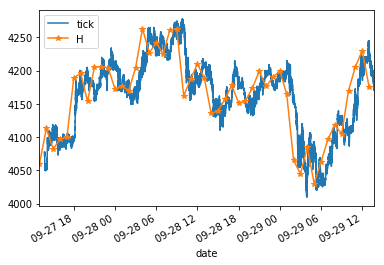

In [64]:
data['rate'].plot(label='tick')
ohlc['close'].plot(marker='*',label=interval)
plt.legend()

In [65]:
features = pd.concat([ohlc, volume], axis=1)

In [66]:
features.describe()

,high,close,open,low,amount
count,49.000000,49.000000,49.000000,49.000000,49.000000
mean,4187.341913,4162.526960,4159.317356,4134.934825,286.545253
std,54.872399,58.407300,60.252192,58.537072,170.198672
min,4062.760000,4030.000000,4031.322507,4010.100000,65.670569
25%,4159.807289,4118.210000,4114.000000,4086.700000,168.620624
50%,4199.990000,4174.000000,4174.000000,4151.000000,235.836415
75%,4220.000000,4204.212901,4195.900000,4170.573564,338.331968
max,4278.000000,4263.000000,4266.094979,4240.000000,758.570510


In [67]:
target = pips
target.describe()

count     48.000000
mean       3.641055
std       38.401730
min     -104.094979
25%      -20.432285
50%        7.573801
75%       24.968278
max       88.900000
dtype: float64

In [68]:
# remove info of the last interval, as there is no target
features = features[:-1]
target = target[:-1]

# Machine Learning

In [69]:
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler 

In [70]:
dataset = pd.concat([features, target], axis=1)
dataset.dropna(inplace=True)
dataset.isnull().sum()

high      0
close     0
open      0
low       0
amount    0
0         0
dtype: int64

In [71]:
dataset = dataset.as_matrix()

In [72]:
train, test = train_test_split(dataset, train_size = 0.8)
X_train = train[:,0:-1]
Y_train = train[:,-1]
X_test = test[:,0:-1]
Y_test = test[:,-1]

In [73]:
print [X_train[0], X_test[0], Y_train[0], Y_test[0]]

[array([ 4215.10989997,  4164.58759549,  4194.00000021,  4151.00000001,
         235.83641523]), array([ 4115.0625    ,  4096.49999502,  4062.7599999 ,  4055.84546024,
         320.09863881]), -85.75000011999964, 24.139999989999978]


In [74]:
# standardizing to 0 mean and var = 1 
scaler = StandardScaler()  
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)

In [75]:
mlp = MLPRegressor(hidden_layer_sizes=(10,10), max_iter=100, alpha=1e-4,
                   verbose=10, tol=1e-4, random_state=1,
                    learning_rate_init=.1)

mlp.fit(X_train, Y_train)
print("Training set score: %f" % mlp.score(X_train, Y_train))
print("Test set score: %f" % mlp.score(X_test, Y_test))

Iteration 1, loss = 874.57664235
Iteration 2, loss = 861.79839599
Iteration 3, loss = 849.61681818
Iteration 4, loss = 833.06928962
Iteration 5, loss = 811.82755249
Iteration 6, loss = 787.31502689
Iteration 7, loss = 768.94163357
Iteration 8, loss = 763.18455864
Iteration 9, loss = 751.68644933
Iteration 10, loss = 733.05920299
Iteration 11, loss = 722.23401449
Iteration 12, loss = 715.58938769
Iteration 13, loss = 699.39245788
Iteration 14, loss = 680.66340939
Iteration 15, loss = 668.21701554
Iteration 16, loss = 650.80559483
Iteration 17, loss = 631.81524010
Iteration 18, loss = 622.06501894
Iteration 19, loss = 615.56338498
Iteration 20, loss = 610.61103276
Iteration 21, loss = 608.42895078
Iteration 22, loss = 600.73000452
Iteration 23, loss = 588.54751899
Iteration 24, loss = 575.27810241
Iteration 25, loss = 561.32159229
Iteration 26, loss = 547.56580966
Iteration 27, loss = 537.49546839
Iteration 28, loss = 533.80415946
Iteration 29, loss = 529.46042447
Iteration 30, loss = 51